In [2]:
%matplotlib inline

# Extract geometries from mongoDB, export as SVG for nesting

This notebook extracts geometries (areas, like polygons of parking spaces) from a mongoDB, then exports all areas in an svg file for nesting with SVGNest.

Created on:  2016-10-28  
Last update: 2016-11-03  
Contact: michael.szell@moovel.com, michael.szell@gmail.com (Michael Szell)

In [5]:
# preliminaries
from __future__ import unicode_literals
import sys
import csv
import os
import math
from random import shuffle, choice, uniform
import random
import pprint
import requests
import gzip
from collections import defaultdict
import time
import datetime
import numpy as np
from scipy import stats
import pyprind
import itertools
import logging
from ast import literal_eval as make_tuple
from collections import OrderedDict
from retrying import retry

import json
from xml.dom import minidom
from shapely.geometry import mapping, shape, LineString, LinearRing, Polygon, MultiPolygon
import shapely
import shapely.ops as ops
from functools import partial
import pyproj
RobinsonProjection = pyproj.Proj("+proj=robin +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
from scipy import spatial
from haversine import haversine
import overpass
apiop = overpass.API(timeout=600)

import pymongo
from pymongo import MongoClient

# plotting stuff
import matplotlib.pyplot as plt
# import mpld3
# mpld3.enable_notebook() # unfortunately, this is too buggy: https://github.com/mpld3/mpld3/issues/193
# mpld3.disable_notebook()

curtime = time.strftime("%Y%m%d_%H%M%S")
pp = pprint.PrettyPrinter(indent=4)

# City parameters (generalize later)
cityname = "vienna" # "amsterdam" b"berlin"

### Functions

In [6]:
def coordinatesToSVGString(coo, xoffset = 0, yoffset = 0, idname = ""):
    svgstring = "\n  <polygon "
    if idname:
        svgstring += "class=\""+idname+"\""
    svgstring += " points=\""
    strxylist = [str(coo[i][0]+xoffset)+","+str(coo[i][1]+yoffset) for i in range(coo.shape[0])]
    for s in strxylist:
        svgstring += s+" "
    svgstring += "\"/>"
    return svgstring

def drawPolygon(poly, title=""): # poly is a shapely Polygon
    x, y = poly.exterior.xy
    fig = plt.figure(figsize=(4,4), dpi=90)
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.plot(x, y)
    
def getLargestSubPolygon(multipoly): # multipoly is a shapely polygon or multipolygon
    # if its a polygon, do nothing, else give largest subpolygon
    if not (isinstance(multipoly, shapely.geometry.multipolygon.MultiPolygon)):
        return multipoly
    else:
        a = 0
        j = 0
        for i in range(len(multipoly)):
            if multipoly[i].area > a:
                j = i
                a = multipoly[i].area
        return multipoly[j]
    
def getSmallestSubPolygon(multipoly): # multipoly is a shapely polygon or multipolygon
    # if its a polygon, do nothing, else give largest subpolygon
    if not (isinstance(multipoly, shapely.geometry.multipolygon.MultiPolygon)):
        return multipoly
    else:
        a = float("inf")
        j = 0
        for i in range(len(multipoly)):
            if multipoly[i].area < a:
                j = i
                a = multipoly[i].area
        return multipoly[j]

def getTwoLargestSubPolygons(multipoly): # multipoly is a shapely polygon or multipolygon
    # if its a polygon, do nothing, else give two largest subpolygon
    if not (isinstance(multipoly, shapely.geometry.multipolygon.MultiPolygon)):
        return multipoly
    else:
        a = [multipoly[i].area for i in range(len(multipoly))]
        sortorder = sorted(range(len(a)), key=lambda k: a[k], reverse=True) # http://stackoverflow.com/questions/7851077/how-to-return-index-of-a-sorted-list
        return MultiPolygon([ multipoly[i] for i in sortorder[0:2] ])
    

In [234]:
a = [1, 4, 2, 6]
sortorder = sorted(range(len(a)), key=lambda k: a[k], reverse=True)
print([ a[i] for i in sortorder[0:2] ])

[6, 4]


In [7]:
# mongo connection
client = MongoClient()
db = client[cityname+'_derived']
ways = db['ways']
cursor = ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]})
numparkingareas = cursor.count()
print(numparkingareas)

1901


In [27]:
# get parking spaces (ONE-OFF)
bar = pyprind.ProgBar(numparkingareas, bar_char='█', update_interval=1)
width = 800
height = 1131
numsheets = 1
hsqu = 2.75
scale = 0.6
binbound = [[0,0], [width, 0], [width, height], [0, height]]
xpos = 0
ypos = 0
yextent = 0
svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
svg += "\n  <polygon class=\"bin\" points=\"0,0 "+str(width)+",0 "+str(width)+","+str(height)+" 0,"+str(height)+"\"/>"
# for i,way in enumerate(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",1)):
for i,way in enumerate(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]})):
    bar.update(item_id = i)
    npway = np.asarray(way["geometry"]["coordinates"])
    npwayxy = np.asarray([RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])])
    npwayxy[:, 0] -= min(npwayxy[:, 0])
    npwayxy[:, 1] -= min(npwayxy[:, 1])
    npwayxy *= scale
    if max(npwayxy[:, 0]) <= width:
        if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
            xdelta = xpos+1
            ydelta = ypos
        else: # new row
            xdelta = 0
            ypos += yextent
            yextent = 0
            ydelta = ypos
            xpos = 0
        svg += "\n  <polygon points=\""
        strxylist = [str(npwayxy[i][0]+xdelta)+","+str(npwayxy[i][1]+ydelta) for i in range(npwayxy.shape[0])]
        for s in strxylist:
            svg += s+" "
        svg += "\"/>"
        yextent = max([yextent, max(npwayxy[:, 1])])
        xpos += max(npwayxy[:, 0])
        if ypos > height * hsqu * numsheets:
            break
    else:
        print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
svg += "\n</svg>"

with open(pathdataout + cityname + "_examplein_parkingareas.svg", "w") as f:
    f.write(svg)

0%                          100%
[█                             ] | ETA: 00:00:30 | Item ID: 101

## Get parking spaces for multiple SVG bins

### Batch 01  
Go from top to bottom, modulo-style

In [ ]:
pathdatain = '/Users/szellmi/Documents/lab-mobviz/_playground/parkingnesting/batch01/newyorkin/'
pathdataout = '/Users/szellmi/Documents/lab-mobviz/_playground/parkingnesting/batch01/newyorkout/'

In [69]:
# get parking spaces (ALL in a city)
width = 800
height = 1131
numsheets = 1
maxarea = 1600000
hsqu = 5
scale = 0.6
maxj = 4

for j in range(maxj):
    bar = pyprind.ProgBar(numparkingareas, bar_char='█', update_interval=1)

    binbound = [[0,0], [width, 0], [width, height], [0, height]]
    xpos = 0
    ypos = 0
    yextent = 0
    svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
    svg += "\n  <polygon class=\"bin\" points=\"0,0 "+str(width)+",0 "+str(width)+","+str(height)+" 0,"+str(height)+"\"/>"
    totalarea = 0
    
    for i,way in enumerate(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",-1)):
        if (i<maxj and i % maxj == j) or (i>=maxj and i % maxj == maxj-j-1):
            bar.update(item_id = i)
            npway = np.asarray(way["geometry"]["coordinates"])
            npwayxy = np.asarray([RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])])
            npwayxy[:, 0] -= min(npwayxy[:, 0])
            npwayxy[:, 1] -= min(npwayxy[:, 1])
            npwayxy *= scale
            if max(npwayxy[:, 0]) <= width:
                if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                    xdelta = xpos+1
                    ydelta = ypos
                else: # new row
                    xdelta = 0
                    ypos += yextent
                    yextent = 0
                    ydelta = ypos
                    xpos = 0
                svg += "\n  <polygon points=\""
                strxylist = [str(npwayxy[i][0]+xdelta)+","+str(npwayxy[i][1]+ydelta) for i in range(npwayxy.shape[0])]
                for s in strxylist:
                    svg += s+" "
                svg += "\"/>"
                yextent = max([yextent, max(npwayxy[:, 1])])
                xpos += max(npwayxy[:, 0])
                try:
                    totalarea += way["properties_derived"]["area"]
                except:
                    pass
#                 if ypos > height * hsqu * numsheets or totalarea > maxarea:
                if totalarea > maxarea * 1.05 **(float(j)):
                    print("Total area exceeded max area")
                    break
            else:
                print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
    svg += "\n</svg>"
    print(str(totalarea))

    with open(pathdatain + cityname + "parking"+ str(j).zfill(3)  +"in.svg", "w") as f:
        f.write(svg)

0%                          100%
[                              ] | ETA: 01:06:280%                          100%
[                              ]

Total area exceeded max area
1600318.0856604031


[                              ] | ETA: 00:27:07 | Item ID: 10%                          100%
[                              ]

1639074.440689429


[██                            ] | ETA: 00:00:09 | Item ID: 6330%                          100%
[                              ]

1610039.7921575473


[                              ] | ETA: 00:00:58 | Item ID: 104

1596705.65588703


### Batch 02
Go from top to bottom and concurently bottom to top, modulo-style

In [316]:
pathdatain = '/Users/szellmi/Documents/lab-mobviz/_playground/parkingnesting/batch02/newyorkin/'
pathdataout = '/Users/szellmi/Documents/lab-mobviz/_playground/parkingnesting/batch02/newyorkout/'

In [319]:
# get parking spaces (ALL in a city)
width = 800
height = 1131
numsheets = 1
maxarea = 1650000
hsqu = 5
scale = 0.6
maxj = 4 # 4

for j in range(maxj):
    bar = pyprind.ProgBar(numparkingareas, bar_char='█', update_interval=1)

    binbound = [[0,0], [width, 0], [width, height], [0, height]]
    xpos = 0
    ypos = 0
    yextent = 0
    svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
    svg += "\n  <polygon class=\"bin\" points=\"0,0 "+str(width)+",0 "+str(width)+","+str(height)+" 0,"+str(height)+"\"/>"
    totalarea = 0
    
    for i,(way,wayr) in enumerate(zip(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",-1),ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",1))):
        if (i<maxj and i % maxj == j) or (i>=maxj and i % maxj == maxj-j-1):
            bar.update(item_id = i)
            npway = np.asarray(way["geometry"]["coordinates"])
            npwayxy = np.asarray([RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])])
            npwayxy[:, 0] -= min(npwayxy[:, 0])
            npwayxy[:, 1] -= min(npwayxy[:, 1])
            npwayxy *= scale
            if max(npwayxy[:, 0]) <= width:
                if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                    xdelta = xpos+1
                    ydelta = ypos
                else: # new row
                    xdelta = 0
                    ypos += yextent
                    yextent = 0
                    ydelta = ypos
                    xpos = 0
                svg += "\n  <polygon points=\""
                strxylist = [str(npwayxy[i][0]+xdelta)+","+str(npwayxy[i][1]+ydelta) for i in range(npwayxy.shape[0])]
                for s in strxylist:
                    svg += s+" "
                svg += "\"/>"
                yextent = max([yextent, max(npwayxy[:, 1])])
                xpos += max(npwayxy[:, 0])
                try:
                    totalarea += way["properties_derived"]["area"]
                except:
                    pass
#                 if ypos > height * hsqu * numsheets or totalarea > maxarea:
                if totalarea > maxarea * 1.05 **(float(j)):
                    print("Total area exceeded max area")
                    break
            else:
                print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
        if (i<maxj and i % maxj == j) or (i>=maxj and i % maxj == maxj-j-1):
            bar.update(item_id = i)
            npway = np.asarray(wayr["geometry"]["coordinates"])
            npwayxy = np.asarray([RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])])
            npwayxy[:, 0] -= min(npwayxy[:, 0])
            npwayxy[:, 1] -= min(npwayxy[:, 1])
            npwayxy *= scale
            if max(npwayxy[:, 0]) <= width:
                if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                    xdelta = xpos+1
                    ydelta = ypos
                else: # new row
                    xdelta = 0
                    ypos += yextent
                    yextent = 0
                    ydelta = ypos
                    xpos = 0
                svg += "\n  <polygon points=\""
                strxylist = [str(npwayxy[i][0]+xdelta)+","+str(npwayxy[i][1]+ydelta) for i in range(npwayxy.shape[0])]
                for s in strxylist:
                    svg += s+" "
                svg += "\"/>"
                yextent = max([yextent, max(npwayxy[:, 1])])
                xpos += max(npwayxy[:, 0])
                try:
                    totalarea += wayr["properties_derived"]["area"]
                except:
                    pass
#                 if ypos > height * hsqu * numsheets or totalarea > maxarea:
                if totalarea > maxarea * 1.00 **(float(j)):
                    print("Total area exceeded max area")
                    break
            else:
                print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
    svg += "\n</svg>"
    print(str(totalarea))

    with open(pathdatain + cityname + "parking"+ str(j).zfill(3)  +"in.svg", "w") as f:
        f.write(svg)

0%                          100%
[                              ] | ETA: 00:53:050%                          100%
[                              ]

3259574.2587525714


[                              ] | ETA: 00:50:56 | Item ID: 10%                          100%
[                              ]

3395620.758942315


[                              ] | ETA: 00:53:19 | Item ID: 20%                          100%
[                              ]

3266089.839693005


[                              ] | ETA: 00:51:48 | Item ID: 3

3189769.8411985473


### Batch 03
Place biggest pieces on vertical center line, from top to bottom. Make right and left (mirrored) parts, so that gravity of SVGNest flows towards center line.

Technically, make first a half-sized bin and place the biggest parts on the left. Same for the mirrored right sized part. These need to be diffed out with Illustrator (look for automatized options later).

In [155]:
pathdatain = '/Users/szellmi/Documents/lab-mobviz/_playground/parkingnesting/batch03/newyorkin/'
pathdataout = '/Users/szellmi/Documents/lab-mobviz/_playground/parkingnesting/batch03/newyorkout/'

In [264]:
# get parking spaces (ALL in a city)
width = 800
height = 1131
maxarea = 1650000*0.31
maxbigparts = 50
scale = 0.6
maxbins = 3
smallvsbig = 8
buffereps = 5
areafactors = [1, 1.14, 1.25, 1.28, 1.29, 1.29]
draw = False

bigbin = Polygon([[0,0], [width,0], [width, maxbins*height], [0, maxbins*height]])
bigbin = bigbin.difference(Polygon([[width/2-1,-1], [width/2-1,maxbins*height-2], [width/2+2,maxbins*height-2], [width/2+2,-1]]))

bigpartstodiff = []
partareastaken = []
ypos = 2
numbigparts = 0
# Determine big parts
for p in range(maxbigparts):
    for i,way in enumerate(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",-1)):
        npway = np.asarray(way["geometry"]["coordinates"])
        npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
        npwayxy = np.asarray([[npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
        objectwidth = max(npwayxy[:, 0])-min(npwayxy[:, 0])
        npwayxy[:, 0] -= (min(npwayxy[:, 0])+objectwidth/2)
        npwayxy[:, 1] -= min(npwayxy[:, 1])
        npwayxy *= scale
        objectwidth *= scale
        objectheight = max(npwayxy[:, 1])
        if objectwidth <= width:
            if ypos >= height*maxbins-1-objectheight: # see if this part still fits
                break
            bigpartstodiff.append( [[npwayxy[k][0]+width/2, npwayxy[k][1]+ypos] for k in range(npwayxy.shape[0])] )
            ypos += objectheight + buffereps
            try:
                partareastaken.append(way["properties_derived"]["area"])
            except:
                pass
        else:
            print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
        numbigparts += 1 # increase number of parts in any case
        if draw:
            drawPolygon(Polygon(bigpartstodiff[-1]), "Big part")
# Export the big parts
svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
for i in range(len(bigpartstodiff)):
    svg += coordinatesToSVGString(np.array(bigpartstodiff[i]), 0, 0)
svg += "\n</svg>"
with open(pathdatain + cityname + "bigparts.svg", "w") as f:
    f.write(svg)
            
# Clip bins into batches and diff the big parts
for j in range(numbigparts):
    bigbin = getLargestSubPolygon(bigbin.difference(Polygon(bigpartstodiff[j])))
        
# Cut the big part into sub-bins
scissorv = Polygon([[width/2-1, -1], [width/2-1, maxbins*height+1], [width/2+1, maxbins*height+1], [width/2+1, -1]])
cutbins = [[], []]
bigbin = getTwoLargestSubPolygons(bigbin.difference(scissorv)) # cut in half vertically

for m in range(len(bigbin)): # cut horizontally
    rest = bigbin[m]
    for i in range(maxbins):
        scissorh = Polygon([[-1, (i+1)*height], [width+1, (i+1)*height], [width+1, (i+1)*height+1], [-1, (i+1)*height+1]])
        temp = rest
        temp = getTwoLargestSubPolygons(temp.difference(scissorh))
        cutbins[m].append(getSmallestSubPolygon(temp))
        rest = getLargestSubPolygon(temp)
        if draw:
            drawPolygon(cutbins[j][-1], "Bin")

# Fill with small parts
for numbin in range(maxbins):
    areafactor = areafactors[numbin]
    for mirrored in range(2):
        if mirrored:
            m = -1
        else:
            m = 1
        binbound = np.array(cutbins[mirrored][numbin].exterior.coords)
        binbound = np.asarray([[m*binbound[i][0],binbound[i][1]-min(binbound[:][1])] for i in range(binbound.shape[0])])
        xpos = 0
        ypos = height+1 # start placing the elements below the bin
        yextent = 0
        svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
        svg += coordinatesToSVGString(binbound, 0, 0, "bin")
        totalarea = 0

        for i,(way,wayr) in enumerate(zip(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",-1).skip(numbigparts),ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",1))):
            if i % (2*smallvsbig*maxbins+mirrored) == numbin: # Go from largest to smallest
                npway = np.asarray(way["geometry"]["coordinates"])
                npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
                npwayxy = np.asarray([[m*npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
                npwayxy[:, 0] -= min(npwayxy[:, 0])
                npwayxy[:, 1] -= min(npwayxy[:, 1])
                npwayxy *= scale
                if max(npwayxy[:, 0]) <= width:
                    if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                        xdelta = xpos+1
                        ydelta = ypos
                    else: # new row
                        xdelta = 0
                        ypos += yextent
                        yextent = 0
                        ydelta = ypos
                        xpos = 0
                    svg += coordinatesToSVGString(npwayxy, xdelta, ydelta)
                    yextent = max([yextent, max(npwayxy[:, 1])])
                    xpos += max(npwayxy[:, 0])
                    try:
                        totalarea += way["properties_derived"]["area"]
                    except:
                        pass
                    if totalarea > maxarea * areafactor:
                        print("Total area exceeded max area")
                        break
                else:
                    print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
            if i % (2*maxbins+mirrored) == numbin: # Go from smallest to smallest
                npway = np.asarray(wayr["geometry"]["coordinates"])
                npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
                npwayxy = np.asarray([[m*npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
                npwayxy[:, 0] -= min(npwayxy[:, 0])
                npwayxy[:, 1] -= min(npwayxy[:, 1])
                npwayxy *= scale
                if max(npwayxy[:, 0]) <= width:
                    if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                        xdelta = xpos+1
                        ydelta = ypos
                    else: # new row
                        xdelta = 0
                        ypos += yextent
                        yextent = 0
                        ydelta = ypos
                        xpos = 0
                    svg += coordinatesToSVGString(npwayxy, xdelta, ydelta)
                    yextent = max([yextent, max(npwayxy[:, 1])])
                    xpos += max(npwayxy[:, 0])
                    try:
                        totalarea += wayr["properties_derived"]["area"]
                    except:
                        pass
                    if totalarea > maxarea * areafactor:
                        print("Total area exceeded max area")
                        break
                else:
                    print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
        svg += "\n</svg>"

        if mirrored:
            with open(pathdatain + cityname + "parking"+ str(numbin).zfill(3)  +"min.svg", "w") as f:
                f.write(svg)
        else:   
            with open(pathdatain + cityname + "parking"+ str(numbin).zfill(3)  +"in.svg", "w") as f:
                f.write(svg)

Total area exceeded max area
Total area exceeded max area
Total area exceeded max area
Total area exceeded max area
Total area exceeded max area
Total area exceeded max area


not mirrored
1
306.235376163
579.451414762
836.162179883
1109.70585502
1224.96659008
mirrored
1
306.235376163
579.451414762
836.162179883
1109.70585502
1224.96659008
not mirrored
-21.2941449849
93.9665900776
342.732460678
561.447348814
796.637259121
950.659266023
1155.38491244
mirrored
-21.2941449849
93.9665900776
342.732460678
561.447348814
796.637259121
950.659266023
1155.38491244


/Users/szellmi/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


not mirrored
-180.340733977
24.3849124352
195.239418405
370.39397174
563.979976006
718.116510348
940.580057498
1076.65192665
1247.81423021
mirrored
-180.340733977
24.3849124352
195.239418405
370.39397174
563.979976006
718.116510348
940.580057498
1076.65192665
1247.81423021


0%                          100%
[                              ]

[305.23537616282698, 273.21603859886528, 256.71076512169094, 273.54367513172326, 115.26073506250977, 248.76587060038, 305.23537616282698, 273.21603859886528, 256.71076512169094, 273.54367513172326, 115.26073506250977, 248.76587060038, 115.26073506250977, 248.76587060038, 218.71488813646138, 235.18991030696779, 154.02200690153987, 204.72564641218631, 170.85450597032903, 115.26073506250977, 248.76587060038, 218.71488813646138, 235.18991030696779, 154.02200690153987, 204.72564641218631, 170.85450597032903, 204.72564641218631, 170.85450597032903, 175.15455333441494, 193.58600426651537, 154.13653434198349, 222.46354714985935, 136.07186915259808, 171.16230356264859, 109.02377321496606, 204.72564641218631, 170.85450597032903, 175.15455333441494, 193.58600426651537, 154.13653434198349, 222.46354714985935, 136.07186915259808, 171.16230356264859, 109.02377321496606]


[                              ] | ETA: 00:52:57

Total area exceeded max area


[████                          ] | ETA: 00:00:210%                          100%
[                              ]

Total area exceeded max area


[                              ] | ETA: 00:49:35 | Item ID: 1

Total area exceeded max area


[████                          ] | ETA: 00:00:19 | Item ID: 10%                          100%
[                              ]

Total area exceeded max area


[█████                         ] | ETA: 00:00:17 | Item ID: 2

Total area exceeded max area


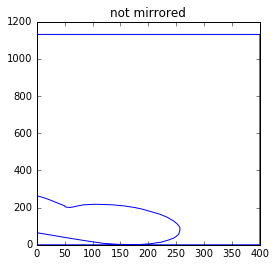

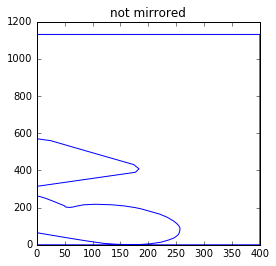

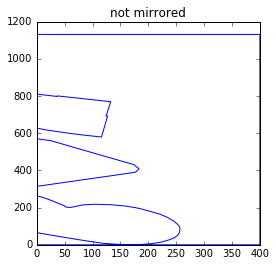

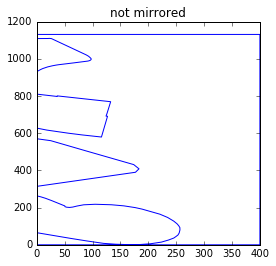

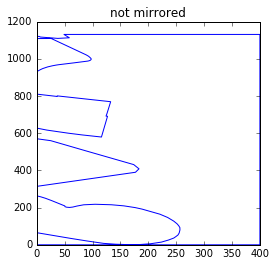

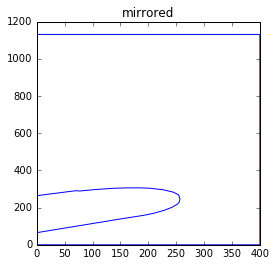

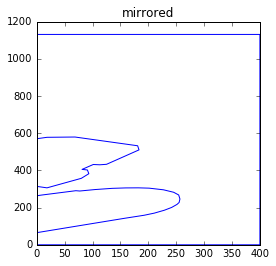

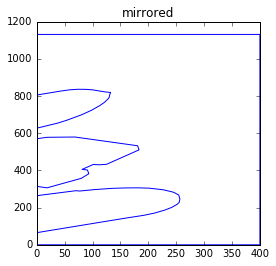

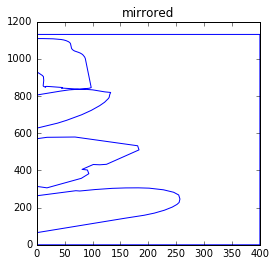

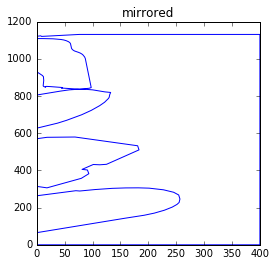

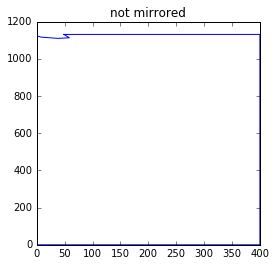

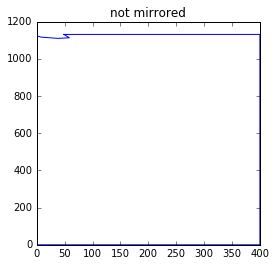

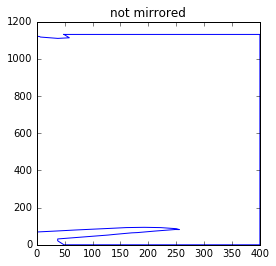

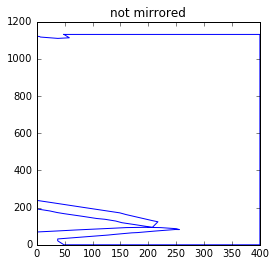

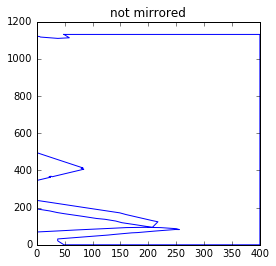

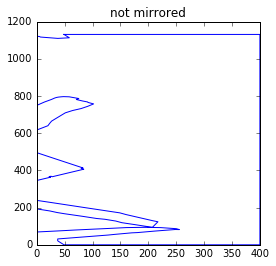

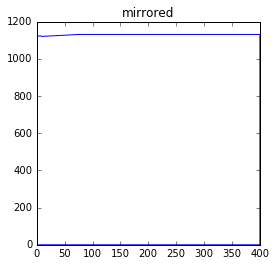

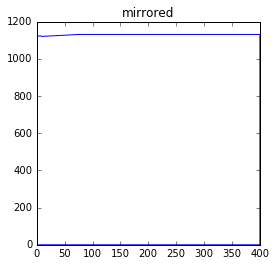

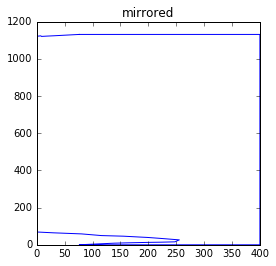

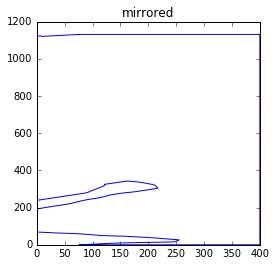

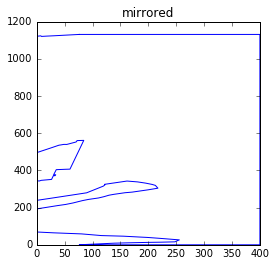

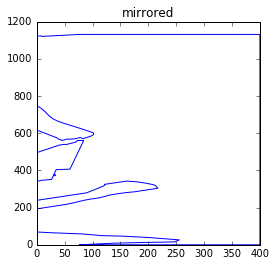

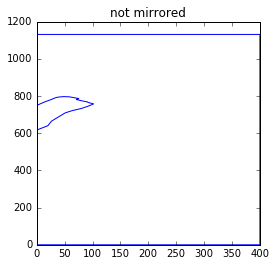

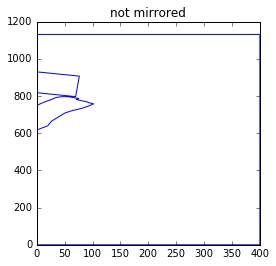

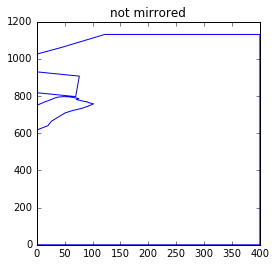

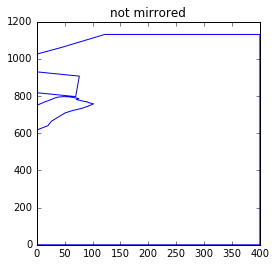

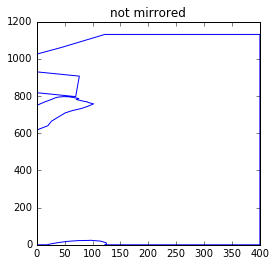

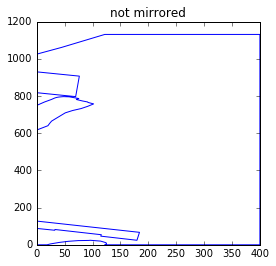

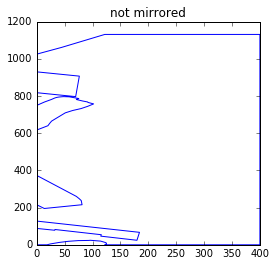

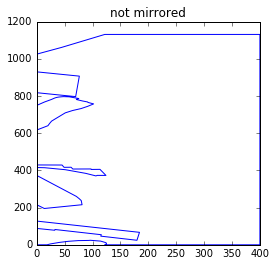

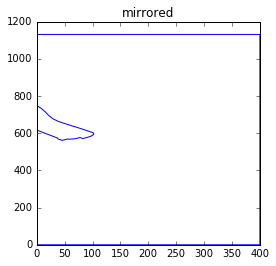

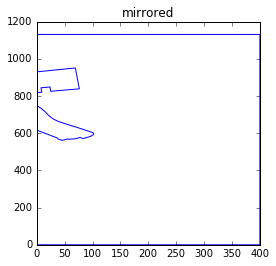

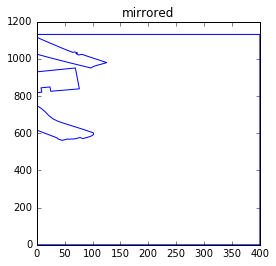

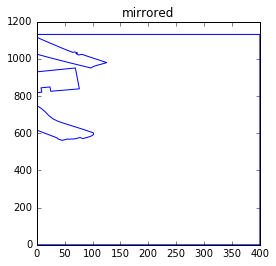

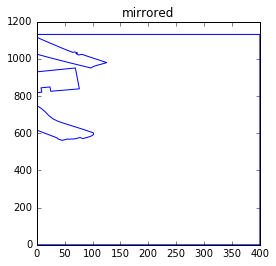

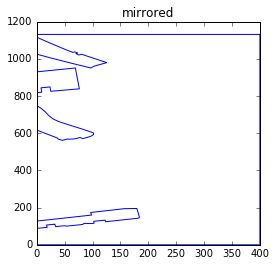

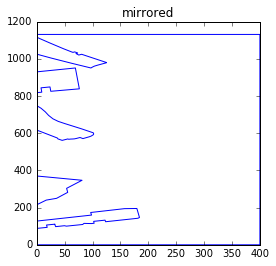

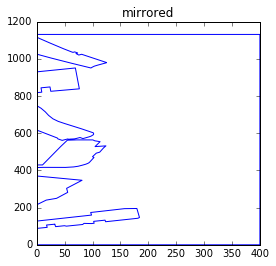

In [190]:
# THIS VERSION DOES NOT WORK CORRECTLY

# get parking spaces (ALL in a city)
width = 800/2
height = 1131
maxarea = 1650000*0.75
maxbigparts = 50
scale = 0.6
maxbins = 3
smallvsbig = 8

# first, prepare bins with the big parts
bins = []
binsm = []
bintotalareastaken = []
bigpartstodiff = []
bigpartstodiffm = []
yoffsets = [1]
numbigparts = 0
objectheights = []

# Determine big parts and clipped bins
for numbin in range(maxbins):
    for mirrored in [0,1]:
        numbigpartshere = 0
        if mirrored:
            print("mirrored")
            m = -1
        else:
            print("not mirrored")
            m = 1
        ypos = yoffsets[-1]
        totalarea = 0
        for i,way in enumerate(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",-1).skip(numbigparts+numbigpartshere)):
            npway = np.asarray(way["geometry"]["coordinates"])
            npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
            npwayxy = np.asarray([[m*npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
            objectwidth = max(npwayxy[:, 0])-min(npwayxy[:, 0])
            npwayxy[:, 0] -= (min(npwayxy[:, 0])+objectwidth/2)
            npwayxy[:, 1] -= min(npwayxy[:, 1])
            npwayxy *= scale
            objectwidth *= scale
            objectheights.append(max(npwayxy[:, 1]))
            if objectwidth/2 <= width:
                ydelta = ypos
                if mirrored:
                    bigpartstodiffm.append( [[npwayxy[k][0]+0, npwayxy[k][1]+ydelta] for k in range(npwayxy.shape[0])] )
                else:
                    bigpartstodiff.append( [[npwayxy[k][0]+0, npwayxy[k][1]+ydelta] for k in range(npwayxy.shape[0])] )
                try:
                    totalarea += way["properties_derived"]["area"]/2
                except:
                    pass
                print(str(ypos))
                if ypos > height:
                    ypos += max(npwayxy[:, 1])
                    break
                numbigpartshere += 1
                ypos += max(npwayxy[:, 1])
#                 print(str(max(npwayxy[:, 1])))
            else:
                print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
        bintotalareastaken.append(totalarea)
        mainbin = Polygon([[0,0], [width, 0], [width, height], [0, height]])
        if mirrored:
            for j in range(numbigparts, numbigparts+numbigpartshere):
                temp = mainbin.difference(Polygon(bigpartstodiffm[j]))
                # http://stackoverflow.com/questions/39142876/python-shapely-check-if-a-polygon-is-a-multipolygon
                if not (isinstance(temp, shapely.geometry.multipolygon.MultiPolygon)): # This might be a MultiPolygon due to multiple components
                    mainbin = mainbin.difference(Polygon(bigpartstodiffm[j]))
                else:
                    mainbin = temp[0]
                drawPolygon(mainbin, "mirrored")
            binsm.append(np.asarray(mainbin.exterior.coords))
        else: 
            for j in range(numbigparts, numbigparts+numbigpartshere):
                temp = mainbin.difference(Polygon(bigpartstodiff[j]))
                # http://stackoverflow.com/questions/39142876/python-shapely-check-if-a-polygon-is-a-multipolygon
                if not (isinstance(temp, shapely.geometry.multipolygon.MultiPolygon)): # This might be a MultiPolygon due to multiple components
                    mainbin = mainbin.difference(Polygon(bigpartstodiff[j]))
                else:
                    mainbin = temp[0]
                drawPolygon(mainbin, "not mirrored")
            bins.append(np.asarray(mainbin.exterior.coords))
        if mirrored:
#             yoffsets.append(height-ypos+max(npwayxy[:, 1]))
            yoffsets.append(ypos-height-max(npwayxy[:, 1])-objectheights[-2])
            numbigparts += (numbigpartshere-1)

print(objectheights)
# sys.exit()
          
# Add small parts to bins and export
for numbin in range(maxbins):
    bar = pyprind.ProgBar(numparkingareas, bar_char='█', update_interval=1)
    for mirrored in [0,1]:
        if mirrored:
            binbound = binsm[numbin]
            m = -1
        else:
            binbound = bins[numbin]
            m = 1
        xpos = 0
        ypos = height+1 # start placing the elements below the bin
        yextent = 0
        svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
        svg += coordinatesToSVGString(binbound, 0, 0, "bin")
        totalarea = bintotalareastaken[numbin]

        for i,(way,wayr) in enumerate(zip(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",-1).skip(numbigparts),ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}]}).sort("properties_derived.area",1))):
            if i % (2*smallvsbig*maxbins-mirrored) == numbin:
                bar.update(item_id = i)
                npway = np.asarray(way["geometry"]["coordinates"])
                npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
                npwayxy = np.asarray([[m*npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
                npwayxy[:, 0] -= min(npwayxy[:, 0])
                npwayxy[:, 1] -= min(npwayxy[:, 1])
                npwayxy *= scale
                if max(npwayxy[:, 0]) <= width:
                    if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                        xdelta = xpos+1
                        ydelta = ypos
                    else: # new row
                        xdelta = 0
                        ypos += yextent
                        yextent = 0
                        ydelta = ypos
                        xpos = 0
                    svg += coordinatesToSVGString(npwayxy, xdelta, ydelta)
                    yextent = max([yextent, max(npwayxy[:, 1])])
                    xpos += max(npwayxy[:, 0])
                    try:
                        totalarea += way["properties_derived"]["area"]
                    except:
                        pass
                    if totalarea > maxarea-bintotalareastaken[numbin]:
                        print("Total area exceeded max area")
                        break
                else:
                    print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
            if i % (2*maxbins-mirrored) == numbin:
                bar.update(item_id = i)
                npway = np.asarray(wayr["geometry"]["coordinates"])
                npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
                npwayxy = np.asarray([[m*npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
                npwayxy[:, 0] -= min(npwayxy[:, 0])
                npwayxy[:, 1] -= min(npwayxy[:, 1])
                npwayxy *= scale
                if max(npwayxy[:, 0]) <= width:
                    if xpos + max(npwayxy[:, 0]) + 1 <= width: # there is space in this row
                        xdelta = xpos+1
                        ydelta = ypos
                    else: # new row
                        xdelta = 0
                        ypos += yextent
                        yextent = 0
                        ydelta = ypos
                        xpos = 0
                    svg += coordinatesToSVGString(npwayxy, xdelta, ydelta)
                    yextent = max([yextent, max(npwayxy[:, 1])])
                    xpos += max(npwayxy[:, 0])
                    try:
                        totalarea += wayr["properties_derived"]["area"]
                    except:
                        pass
                    if totalarea > maxarea:
                        print("Total area exceeded max area")
                        break
                else:
                    print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
        svg += "\n</svg>"

        if mirrored:
            with open(pathdatain + cityname + "parking"+ str(numbin).zfill(3)  +"min.svg", "w") as f:
                f.write(svg)
        else:   
            with open(pathdatain + cityname + "parking"+ str(numbin).zfill(3)  +"in.svg", "w") as f:
                f.write(svg)

### Batch 04
Like batch 03, but with the following improvements:  
1. add buffer around big tiles ✔️
2. give more bin space for small tiles on top of bins ✔️
3. pre-select tiles from DB and exhaust them fully (and uniquely!)
4. do not order big tiles by size, but more randomly ✔️
5. add id as class ✔️
6. prevent shadows

In [12]:
pathdatain = '/Users/szellmi/Documents/lab-mobviz/_playground/parking-nesting/batch04/'+cityname+'in/'
pathdataout = '/Users/szellmi/Documents/lab-mobviz/_playground/parking-nesting/batch04/'+cityname+'out/'
parameters = {"berlin":{"maxbigparts":50, "maxbins":7}, "newyork":{"maxbigparts":50, "maxbins":5}, "stuttgart":{"maxbigparts":30, "maxbins":2}}

In [14]:
# get parking spaces (ALL in a city)
random.seed(0)
maxbigparts = 30
scale = 0.6
binareafactor = 0.8 #1.75
maxbins = 4
smallvsmedium = 11
buffereps = 5
height = 800 # 1131
width = 800 - 1.5*buffereps
draw = False
eps = 0.000001

bigbin = Polygon([[0,0], [width,0], [width, maxbins*height], [0, maxbins*height]])
bigbin = bigbin.difference(Polygon([[width/2-eps,-1], [width/2-eps,maxbins*height-2], [width/2+eps,maxbins*height-2], [width/2+eps,-1]]))

# pre-select all parts
idsused = set()
idsnotused = set()
indicesused = set()
alltiles = []
for i,way in enumerate(ways.find({"$and": [{"properties.amenity": "parking"}, {"geometry.type": "Polygon"}, {"properties_derived.area": { "$gte": 12 }}]}).sort("properties_derived.area",-1)):
    npway = np.asarray(way["geometry"]["coordinates"])
    npwayxy = [RobinsonProjection(npway[i][0], npway[i][1]) for i in range(npway.shape[0])]
    npwayxy = np.asarray([[npwayxy[i][0],-npwayxy[i][1]] for i in range(npway.shape[0])])
    objectwidth = max(npwayxy[:, 0])-min(npwayxy[:, 0])
    npwayxy[:, 0] -= min(npwayxy[:, 0])
    npwayxy[:, 1] -= min(npwayxy[:, 1])
    npwayxy *= scale
    objectwidth *= scale
    if objectwidth < width:
        objectheight = max(npwayxy[:, 1])
        idsnotused.add(way["_id"])
        coo = [[npwayxy[k][0], npwayxy[k][1]] for k in range(npwayxy.shape[0])]
        area = Polygon(coo).buffer(buffereps/2).area
    #     print(str(area))
    #     print(str(Polygon(coo).area))
    #     print(str(way["properties_derived"]["area"]))
        alltiles.append( { "_id": way["_id"], "width": objectwidth, "height": objectheight, "area": area, "coordinates": coo })
    else:
        print("Object "+str(way["_id"])+" was too wide (" +str(objectwidth)+ " pixel) and was ignored.")
    
bigpartstodiff = []
partareastaken = []
ypos = -0.5*buffereps
numbigparts = 0
randomizedindices = list(range(maxbigparts))
shuffle(randomizedindices)
# Determine big parts
for i in randomizedindices:
    tile = alltiles[i]
    if ypos >= height*maxbins-1-tile["height"]: # see if this part still fits
        break
    tile["coordinates"] = [[tile["coordinates"][k][0]+width/2-tile["width"]/2, tile["coordinates"][k][1]+ypos] for k in range(np.array(tile["coordinates"]).shape[0])]
    bigpartstodiff.append( tile )
    ypos += tile["height"] + 1*buffereps
        
    indicesused.add(i)
    idsused.add(tile["_id"])
    idsnotused.remove(tile["_id"])
    numbigparts += 1 # increase number of parts in any case
    if draw:
        drawPolygon(Polygon(bigpartstodiff[-1]["coordinates"]), "Big part")

# Export the big parts
svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
for i in range(len(bigpartstodiff)):
    svg += coordinatesToSVGString(np.array(bigpartstodiff[i]["coordinates"]), 0, 0, str(bigpartstodiff[i]["_id"]))
svg += "\n</svg>"
with open(pathdataout + "bigparts.svg", "w") as f:
    f.write(svg)
            
# Clip bins into batches and diff the big parts
for j in range(numbigparts):
    bigbin = getLargestSubPolygon(bigbin.difference(Polygon(bigpartstodiff[j]["coordinates"]).buffer(1.75*buffereps, 1, 2, 2)))
        
# Cut the big part into sub-bins
scissorv = Polygon([[width/2-eps, -1], [width/2-eps, maxbins*height+1], [width/2+eps, maxbins*height+1], [width/2+eps, -1]])
cutbins = [[], []]
bigbin = getTwoLargestSubPolygons(bigbin.difference(scissorv)) # cut in half vertically

for m in range(len(bigbin)): # cut horizontally
    rest = bigbin[m]
    for i in range(maxbins):
        scissorh = Polygon([[-1, (i+1)*height], [width+1, (i+1)*height], [width+1, (i+1)*height+eps], [-1, (i+1)*height+eps]])
        temp = rest
        temp = getTwoLargestSubPolygons(temp.difference(scissorh))
        cutbins[m].append(getSmallestSubPolygon(temp).buffer(0.75*buffereps, 1, 2, 2))
        rest = getLargestSubPolygon(temp)
        if draw:
            drawPolygon(cutbins[m][-1], "Bin")

# Fill with small parts
remainingtiles = len(idsnotused)
randomizedindices_medium = list(range(round(remainingtiles/smallvsmedium)+numbigparts))
randomizedindices_medium = list(set(randomizedindices_medium) - indicesused)
shuffle(randomizedindices_medium)
randomizedindices_small = set(list(range(remainingtiles+numbigparts))) - set(randomizedindices_medium)
randomizedindices_small = list(randomizedindices_small - indicesused)
shuffle(randomizedindices_small)

imedium = 0
ismall = 0
for numbin in range(maxbins):
    for mirrored in [0,1]:
        if mirrored:
            m = -1
        else:
            m = 1
        binarea = binareafactor*cutbins[mirrored][numbin].area
        binbound = np.array(cutbins[mirrored][numbin].exterior.coords)
        binbound = np.asarray([[-m*(binbound[i,0]-min(binbound[:,0])/2),binbound[i,1]-min(binbound[:,1])] for i in range(binbound.shape[0])])
        xpos = 0
        ypos = height+1 # start placing the elements below the bin
        yextent = 0
        svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height)+"px\">"
        svg += coordinatesToSVGString(binbound, 0, 0, "bin")
        totalarea = 0
        
        for j in range(len(idsnotused)):
            if len(idsnotused) == 0:
                    break
            try:
                i = randomizedindices_medium[imedium]
                imedium += 1
            except: # no more medium tiles left
                i = randomizedindices_small[ismall]
                ismall += 1
            tile = alltiles[i]
            if tile["width"] <= width:
                if xpos + tile["width"] + 1 <= width: # there is space in this row
                    xdelta = m*(xpos+1)
                    ydelta = ypos
                else: # new row
                    xdelta = 0
                    ypos += yextent
                    yextent = 0
                    ydelta = ypos
                    xpos = 0
                svg += coordinatesToSVGString(np.array([[m*tile["coordinates"][k][0], tile["coordinates"][k][1]] for k in range(np.array(tile["coordinates"]).shape[0])]), xdelta, ydelta, str(tile["_id"]))
                yextent = max([yextent, tile["height"]])
                xpos += tile["width"]+1
                idsused.add(tile["_id"])
                idsnotused.remove(tile["_id"])
                totalarea += tile["area"]
                if totalarea > binarea:
                    print("Tiles area exceeded bin area - bin "+str(numbin).zfill(3)+"_"+str(mirrored)+" completed!")
                    break
            else:
                print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
            for kk in range(smallvsmedium):
                if len(idsnotused) == 0:
                    break
                try:
                    i = randomizedindices_small[ismall]
                    ismall += 1
                except:
                    i = randomizedindices_medium[imedium]
                    imedium += 1
                tile = alltiles[i]
                if tile["width"] <= width:
                    if xpos + tile["width"] + 1 <= width: # there is space in this row
                        xdelta = m*(xpos+1)
                        ydelta = ypos
                    else: # new row
                        xdelta = 0
                        ypos += yextent
                        yextent = 0
                        ydelta = ypos
                        xpos = 0
                    svg += coordinatesToSVGString(np.array([[m*tile["coordinates"][k][0], tile["coordinates"][k][1]] for k in range(np.array(tile["coordinates"]).shape[0])]), xdelta, ydelta, str(tile["_id"]))
                    yextent = max([yextent, tile["height"]])
                    xpos += tile["width"]+1
                    idsused.add(tile["_id"])
                    idsnotused.remove(tile["_id"])
                    totalarea += tile["area"]
                    if totalarea > binarea:
                        print("Tiles area exceeded bin area - bin "+str(numbin).zfill(3)+"_"+str(mirrored)+" completed!")
                        break
                else:
                    print("Object "+str(way["_id"])+" was too wide (" +str(max(npwayxy[:, 0]))+ " pixel) and could not be placed.")
            if totalarea > binarea:
                print("Tiles area exceeded bin area - bin "+str(numbin).zfill(3)+"_"+str(mirrored)+" completed!")
                break
        svg += "\n</svg>"

        if mirrored:
            with open(pathdatain + cityname + "parking"+ str(numbin).zfill(3)  +"min.svg", "w") as f:
                f.write(svg)
        else:   
            with open(pathdatain + cityname + "parking"+ str(numbin).zfill(3)  +"in.svg", "w") as f:
                f.write(svg)

Object 61118221 was too wide (816.302640196 pixel) and was ignored.
Object 61118413 was too wide (842.477633491 pixel) and was ignored.
Tiles area exceeded bin area - bin 000_0 completed!
Tiles area exceeded bin area - bin 000_0 completed!
Tiles area exceeded bin area - bin 000_1 completed!
Tiles area exceeded bin area - bin 000_1 completed!
Tiles area exceeded bin area - bin 001_0 completed!
Tiles area exceeded bin area - bin 001_0 completed!
Tiles area exceeded bin area - bin 001_1 completed!
Tiles area exceeded bin area - bin 001_1 completed!
Tiles area exceeded bin area - bin 002_0 completed!
Tiles area exceeded bin area - bin 002_0 completed!
Tiles area exceeded bin area - bin 002_1 completed!
Tiles area exceeded bin area - bin 002_1 completed!


## After SVGNest was executed, stich back together the parts

In [ ]:
# Collect the pieces that couldn't be fit, and fit into a last bin (TODO)


In [8]:
def getCoordinatesFromSVG(filepath, reversexdir = False, b = 1): # The SVG needs to have polygons with classes, embedded in gs
    doc = minidom.parse(filepath)  # parseString also exists
    path_strings = [path.getAttribute('points') for path
                    in doc.getElementsByTagName('polygon')]
    class_strings = [path.getAttribute('class') for path
                    in doc.getElementsByTagName('polygon')]
    g_strings = [path.getAttribute('transform') for path
                in doc.getElementsByTagName('g')]
    doc.unlink()
    data = dict()
    numbins = 0
    for i,path in enumerate(path_strings):
        if class_strings[i] == "bin":
            numbins += 1
        if numbins == b:
            path = path.split()
            coo = []
            for temp in path:
                p = temp.split(",")
                try:
                    trans = g_strings[i] # looks like this: "translate(484.1119359029915 -1573.8819930603422) rotate(0)"
                    trans = trans.split()
                    trans = [float(trans[0][10:]), float(trans[1][0:-1])]
                except:
                    trans = [0,0]
                if reversexdir:
                    coo.append([-(float(p[0])+trans[0]), float(p[1])+trans[1]])
                else:
                    coo.append([float(p[0])+trans[0], float(p[1])+trans[1]])
    #             print(trans)
            data[class_strings[i]] = coo
        elif numbins > b:
            break
    return data

In [15]:
# read SVG
numbins = 3#maxbins
alltiles = []

# Big parts
alltiles.append(getCoordinatesFromSVG(pathdataout + "bigparts.svg", True, 0))
ypos = 0
xpos = 0

ypos -= 0.75*buffereps
xpos = width/2

# Rest
for i in range(numbins):
    for mirrored in [0,1]:
        if mirrored:
            m = -1
            tiles = getCoordinatesFromSVG(pathdataout + str(i).zfill(3) + "m.svg", mirrored)
        else:
            m = 1
            tiles = getCoordinatesFromSVG(pathdataout + str(i).zfill(3) + ".svg", mirrored)
        for key in tiles:
            if not key == "bin":
                npwayxy = np.array(tiles[key])
                npwayxy = [[npwayxy[k,0]+xpos, npwayxy[k,1]+ypos] for k in range(npwayxy.shape[0])]
                alltiles.append({key: npwayxy})
    ypos += height

# Export
svg = "<svg xmlns=\"http://www.w3.org/2000/svg\" version=\"1.1\" width=\""+str(width)+"px\" height=\""+str(height*numbins)+"px\">"
for j, tile in enumerate(alltiles):
    for i in tile:
        svg += coordinatesToSVGString(np.array([[tile[i][k][0], tile[i][k][1]] for k in range(np.array(tile[i]).shape[0])]), 0, 0, i)
svg += "\n</svg>"
with open(pathdataout + "all.svg", "w") as f:
    f.write(svg)
